= Лабораторная работа 4: BERT =

БВТ2202, Градов Артём Николаевич

Цель - использовать модель BERT для классификации текста на токсичный или не токсичный.

BERT — это модель на основе трансформеров, использующая Self-Attention и Multi-Head Attention для понимания контекста. Она применяется в самых разных NLP-задачах, от классификации текста до вопросно-ответных систем. Ключевая инновация — двунаправленное обучение, что делает её мощнее предыдущих односторонних моделей.

BERT построен на архитектуре Transformer. В отличие от RNN и LSTM, трансформеры:
не используют рекуррентные связи, что ускоряет обучение ; полностью полагаются на механизм Self-Attention, который позволяет модели учитывать контекст слова во всём предложении, а не только в предыдущих токенах.

Self-Attention позволяет модели взвешивать важность каждого слова в предложении относительно других. Как работает?

1.Входные векторы: Каждое слово преобразуется в эмбеддинг (вектор фиксированной размерности, например, 768 для BERT-base).

2.Генерация Query, Key, Value. Из эмбеддингов получают три вектора:
Query (Q) — "запрос" (что ищем?) /
Key (K) — "ключ" (по чему ищем?) /
Value (V) — "значение" (что возвращаем?)

3.Расчёт Attention Score. Определяем, насколько каждое слово важно для текущего:
получаем Attention Score с помощью softmax.

4.Взвешенная сумма Value. Умножаем Attention Score на V

Притом в BERT использует несколько голов внимания!

BERT - мощный инструмент, он позволяет улавливать сложные зависимости(как раз благодаря multi head att.).

*Двунаправленность: Учитывает контекст слева и справа.

*Глубина архитектуры: BERT-large имеет 24 слоя и 340 млн параметров.

*Предобучение на большом корпусе текстов (Wikipedia + BooksCorpus).

Необходимо использовать токенизатор с Hugging Face - разбиваем текст на токены и преобразуем их в ID, которые можно подать в эмбединг-слой.

Также Loss BCE (Binary Cross-Entropy) и оптимизатор Adam/AdamW при learning rate=3e-4. AdamW почти всегда лучше, потому что он исправляет проблему L2-регуляризации в Adam и корректно отделяет decay от градиентов

In [1]:
import torch
from torch import nn, optim, tensor
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/labeled.csv')
texts = data['comment'].values
labels = data['toxic'].values.astype(float)

print(texts[0], labels[0])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=42
)

Верблюдов-то за что? Дебилы, бл...
 1.0


In [5]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
length = 128  #ограничение для оптимизации, меньше padding -> меньше вычислений

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=length,
        return_tensors="pt"
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

train_dataset = ToxicDataset(train_encodings, train_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

In [7]:
class BERTmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_id, attention_mask):
        outputs = self.bert(input_ids=input_id, attention_mask=attention_mask)
        return self.classifier(outputs.last_hidden_state[:, 0, :])

In [8]:
# device = torch.device('cpu')
print("Используемое устройство:", device)
model = BERTmodel()
model.to(device)

batch_size = 32
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01) #поставили вместо lr=5e-5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

def trainEpoch(model, dataloader):
  model.train()
  loss = 0
  for b in dataloader:
    optimizer.zero_grad()
    input_id = b['input_ids'].to(device)
    attention_mask = b['attention_mask'].to(device)###
    labels = b['label'].to(device)

    out = model(input_id, attention_mask)

    loss_by_batch = criterion(out.squeeze(), labels)
    loss_by_batch.backward()
    # grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    # print(f"Grad norm: {grad_norm:.4f}")
    loss += loss_by_batch.item()

  return loss / len(dataloader)

def evaluation(model, dataloader, epoch):
  model.eval()
  preds = []
  probs = []
  labels = []

  with torch.no_grad():
    for b in dataloader:
      input_id = b['input_ids'].to(device)
      attention_mask = b['attention_mask'].to(device)
      b_labels = b['label'].to(device)

      out = model(input_id, attention_mask)
      b_probs = torch.sigmoid(out.squeeze()).cpu().numpy() ##
      b_preds = (b_probs > 0.5).astype(int)

      probs.extend(b_probs)
      preds.extend(b_preds)
      labels.extend(b_labels.cpu().numpy())

    acc = np.mean(np.array(preds)==np.array(labels))
    f1 = f1_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs)
    pr_auc = average_precision_score(labels, probs)

    if epoch == 4:
      cm = confusion_matrix(labels, preds)
      plt.figure(figsize=(8, 6))
      sns.heatmap(
          cm,
          annot=True,
          fmt="d",
          cmap="Blues",
          xticklabels=["Non-Toxic", "Toxic"],
          yticklabels=["Non-Toxic", "Toxic"]
      )
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.title("Confusion Matrix")
      plt.show()

    return [acc, f1, roc_auc, pr_auc]

Используемое устройство: cuda


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EPOCH 0 / 4
Train Loss: 0.2848, Accuracy: 92.553191%
F1: 0.8844, ROC-AUC: 0.9754, PR-AUC: 0.9486
EPOCH 1 / 4
Train Loss: 0.1661, Accuracy: 92.876966%
F1: 0.8890, ROC-AUC: 0.9758, PR-AUC: 0.9517
EPOCH 2 / 4
Train Loss: 0.1114, Accuracy: 92.599445%
F1: 0.8825, ROC-AUC: 0.9762, PR-AUC: 0.9501
EPOCH 3 / 4
Train Loss: 0.0692, Accuracy: 92.553191%
F1: 0.8832, ROC-AUC: 0.9747, PR-AUC: 0.9452


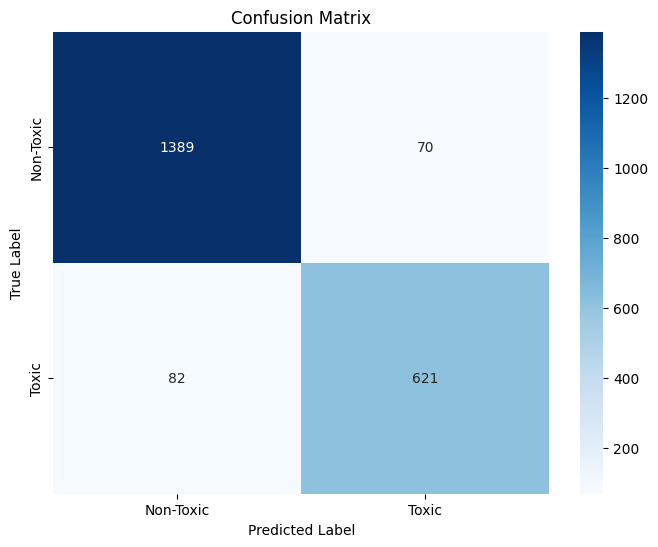

EPOCH 4 / 4
Train Loss: 0.0459, Accuracy: 92.969473%
F1: 0.8910, ROC-AUC: 0.9752, PR-AUC: 0.9446


In [9]:
n_epochs = 5
for e in range(n_epochs):
  loss = trainEpoch(model, train_loader)
  res = evaluation(model, test_loader, e)
  print("EPOCH", e, "/", n_epochs-1)
  print(f"Train Loss: {loss:.4f}, Accuracy: {res[0]*100:.6f}%")
  print(f"F1: {res[1]:.4f}, ROC-AUC: {res[2]:.4f}, PR-AUC: {res[3]:.4f}")

EPOCH 0 / 4
Train Loss: 0.2832, Accuracy: 91.165587%
F1: 0.8548, ROC-AUC: 0.9735, PR-AUC: 0.9483

EPOCH 4 / 4
Train Loss: 0.0429, Accuracy: 92.876966%
F1: 0.8871, ROC-AUC: 0.9728, PR-AUC: 0.9451

EPOCH 0 / 4
Train Loss: 0.2803, Accuracy: 93.663275%
F1: 0.9052, ROC-AUC: 0.9778, PR-AUC: 0.9545

EPOCH 4 / 4
Train Loss: 0.0349, Accuracy: 91.905643%
F1: 0.8747, ROC-AUC: 0.9694, PR-AUC: 0.9405

EPOCH 0 / 4
Train Loss: 0.6430, Accuracy: 67.483811%
F1: 0.0000, ROC-AUC: 0.7928, PR-AUC: 0.6275

EPOCH 4 / 4
Train Loss: 0.6406, Accuracy: 67.483811%
F1: 0.0000, ROC-AUC: 0.4674, PR-AUC: 0.3121

In [10]:
def predict_toxicity(model, texts):
    model.eval()

    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=length,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs.squeeze()).cpu().numpy()
        preds = (probs > 0.5).astype(int)

    return probs, preds

toxic_texts = [
    "нормальный комментарий",
    "Ненавижу Ненавижу Ненавижу"
]
probs, preds = predict_toxicity(model, toxic_texts)

for text, prob, pred in zip(toxic_texts, probs, preds):
    print(f"Текст: {text}")
    print(f"Вероятность токсичности: {prob:.4f} | Предсказание: {'Toxic' if pred else 'Non-Toxic'}\n")

Текст: нормальный комментарий
Вероятность токсичности: 0.0292 | Предсказание: Non-Toxic

Текст: Ненавижу Ненавижу Ненавижу
Вероятность токсичности: 0.9437 | Предсказание: Toxic



F1 - Баланс между precision и recall (важно при дисбалансе классов)

ROC-AUC - Площадь под ROC-кривой (чувствительность к ранжированию)

PR-AUC - Площадь под Precision-Recall кривой (важно для дисбалансированных данных)